# Explanable AI with Fashion MNIST

In [113]:
## installations
#!pip3 install shap

In [1]:
## imports
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap

### Loading Data

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data',                          
    train=True,                             
    download=False,                          
    transform=transforms.Compose([transforms.ToTensor()])     
)

test_set = torchvision.datasets.FashionMNIST(
    root='./data',                          
    train=False,                             
    download=False,                          
    transform=transforms.Compose([transforms.ToTensor()])     
)

In [3]:
batch_size=128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle = False)

### Exploring Data

In [5]:
print("Size of training dataset :", len(train_set))
print("Size of testing dataset :", len(test_set))
print("Classes :" ,train_set.targets.unique().numpy())
print("Classes count :", train_set.targets.bincount().numpy())  
print()

image, label = next(iter(train_set))
print("Shape of an image :",image.shape)

Size of training dataset : 60000
Size of testing dataset : 10000
Classes : [0 1 2 3 4 5 6 7 8 9]
Classes count : [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]

Shape of an image : torch.Size([1, 28, 28])


CLASSES:  
**Index**$~~~~~~~~~$**Label**  
$~~$0$~~~~~~~~~~~$	T-shirt/top  
$~~$1$~~~~~~~~~~~$	Trouser  
$~~$2$~~~~~~~~~~~$	Pullover  
$~~$3$~~~~~~~~~~~$	Dress  
$~~$4$~~~~~~~~~~~$	Coat  
$~~$5$~~~~~~~~~~~$	Sandal  
$~~$6$~~~~~~~~~~~$	Shirt  
$~~$7$~~~~~~~~~~~$	Sneaker  
$~~$8$~~~~~~~~~~~$	Bag  
$~~$9$~~~~~~~~~~~$	Ankle boot  

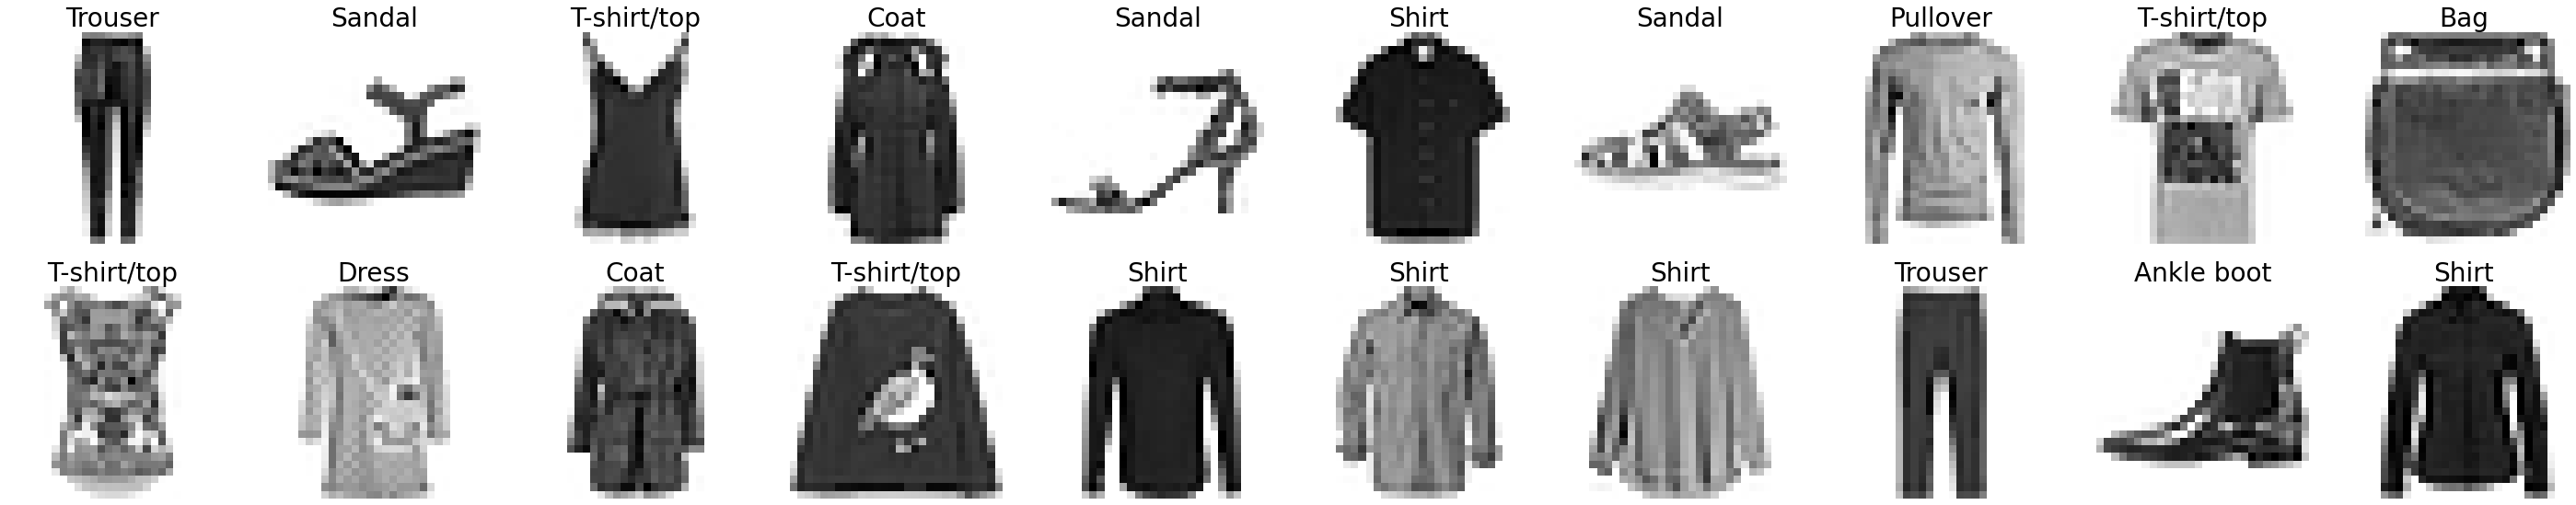

In [45]:
## diplaying
how_many_to_plot = 20

display_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True
)

plt.figure(figsize=(50,50))
for i, batch in enumerate(display_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    plt.imshow(-image.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(train_set.classes[label.item()], fontsize=28)
    if (i >= how_many_to_plot): break
plt.show()

### Building Convolution Neural Network

In [5]:
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        return out
    
model = Network1()

### Training

In [7]:
# Cross Entropy Loss 
error = nn.CrossEntropyLoss() # for calculating softmax and cross entropy loss

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [131]:
# CNN model training
for epoch in range(15):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = model(images) # Pass Batch
        loss = error(preds, labels) # Calculate Loss

        optimizer.zero_grad() # reinitialize gradients
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += preds.argmax(dim=1).eq(labels).sum().item()
        

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "Total loss:", total_loss,
        "accuracy :", 100.0 * total_correct / len(train_set)
    )

epoch 0 total_correct: 40685 Total loss: 774.4632860124111 accuracy : 67.80833333333334
epoch 1 total_correct: 46289 Total loss: 289.5013282299042 accuracy : 77.14833333333333
epoch 2 total_correct: 47581 Total loss: 275.388238966465 accuracy : 79.30166666666666
epoch 3 total_correct: 47948 Total loss: 267.728762447834 accuracy : 79.91333333333333
epoch 4 total_correct: 48095 Total loss: 262.6609227359295 accuracy : 80.15833333333333
epoch 5 total_correct: 48299 Total loss: 263.1102189719677 accuracy : 80.49833333333333
epoch 6 total_correct: 46456 Total loss: 316.8040799200535 accuracy : 77.42666666666666
epoch 7 total_correct: 48132 Total loss: 267.32273134589195 accuracy : 80.22
epoch 8 total_correct: 47630 Total loss: 283.71559500694275 accuracy : 79.38333333333334
epoch 9 total_correct: 47062 Total loss: 310.4852482378483 accuracy : 78.43666666666667
epoch 10 total_correct: 47105 Total loss: 298.96252316236496 accuracy : 78.50833333333334
epoch 11 total_correct: 46172 Total loss: 

### Testing

In [10]:
correct = 0
total = 0
predictions = []
actual = []
for images, labels in test_loader:
    preds = model(images)
    total += len(labels) 
    correct += preds.argmax(dim=1).eq(labels).sum().item()
    predictions+=preds.argmax(dim=1).tolist()
    actual+=labels.tolist()

accuracy = 100.0 * correct / total

Accuracy on testing data :90.11%
confusion matrix:


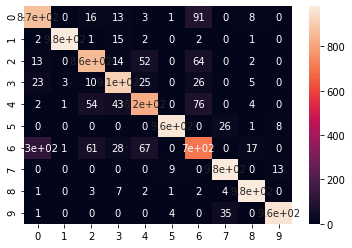

In [11]:
print("Accuracy on testing data :{}%".format(accuracy))
print("confusion matrix:")
cm = confusion_matrix(actual, predictions)
sns.heatmap(cm, annot=True)
plt.show()

### Saving Model

In [51]:
model.eval()
torch.save(model, "models/cnnFMNIIST.pt")

### Loading

In [6]:
model = torch.load("models/cnnFMNIIST.pt")


### SHAP

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
images_dict = dict()

for i, l in enumerate(labels.tolist()):
    if len(images_dict)==10:
        break
    
    if l not in images_dict.keys():
        images_dict[l] = images[i].reshape((28, 28))

        
# Function to plot images
def plot_categories(images):
    fig, axes = plt.subplots(1, 11, figsize=(16, 2))
    axes = axes.flatten()

    # Plot an empty canvas
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')

    # Plot an image for every category
    for k,v in images.items():
        ax = axes[k+1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"{class_names[k]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

In [136]:

shap_loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle = False)
batch = next(iter(shap_loader))
images, lables = batch
e = shap.DeepExplainer(model, images[:990])

test_images= images[990:]
test_lables= lables[990:]

shap_values = e.shap_values(test_images)

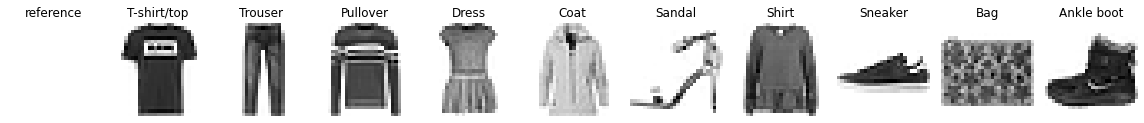

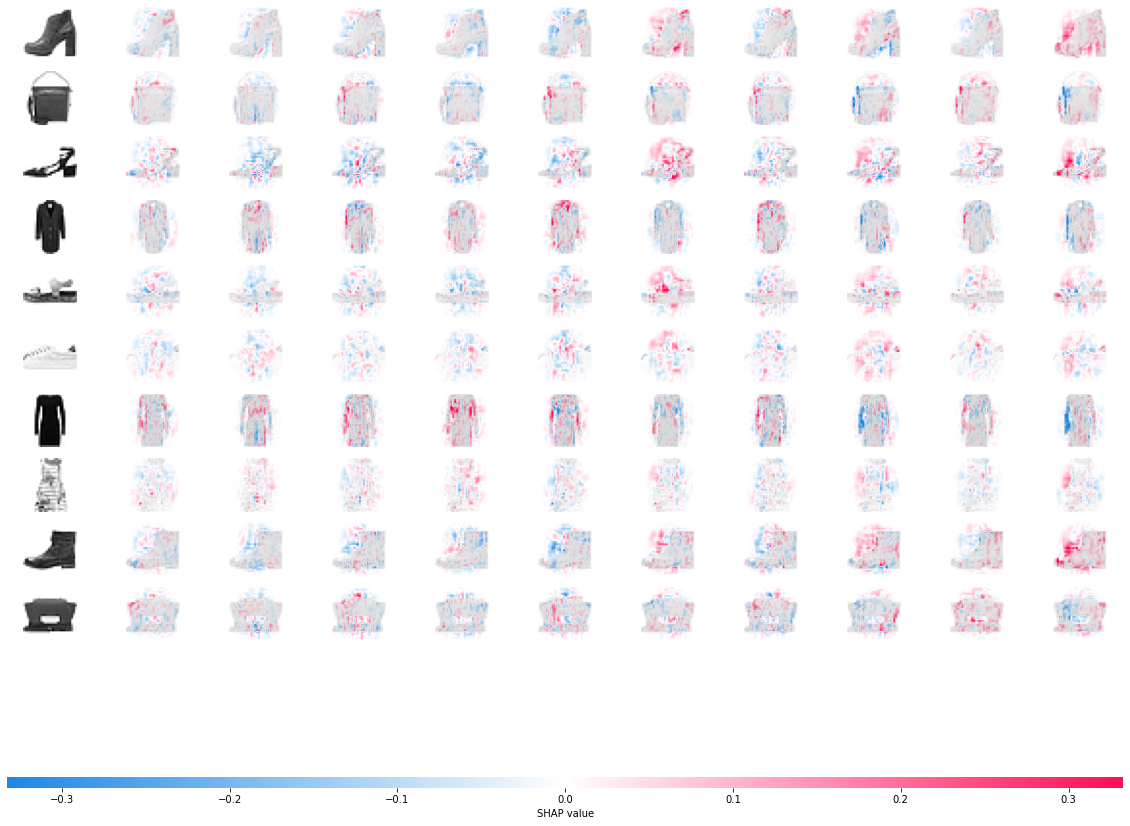

In [137]:

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

plot_categories(images_dict)
shap.image_plot(shap_numpy, -test_numpy)

In [134]:
preds = model(test_images)
print("Prediction :", [ class_names[i] for i in preds.argmax(dim=1) ])
print("Actual : ", [ class_names[i] for i in test_lables])
print("Correct :", preds.argmax(dim=1).eq(test_lables))

Prediction : ['Ankle boot', 'Bag', 'Sandal', 'Coat', 'Sneaker', 'Sneaker', 'Dress', 'Dress', 'Ankle boot', 'Bag']
Actual :  ['Ankle boot', 'Bag', 'Sandal', 'Coat', 'Sandal', 'Sneaker', 'Dress', 'Dress', 'Ankle boot', 'Bag']
Correct : tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True])


## Grad- CAM

In [53]:
last_dense_layer = model.fc1



gap_weights=[]
for param in model.parameters():
    gap_weights+=[param]

gap_weights[-2].shape

torch.Size([10, 512])

In [55]:
images, labels = next(iter(train_loader))
image=images[0]
label = labels[0]

In [57]:
model.forward(images).shape

torch.Size([128, 10])

In [69]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [95]:
h = model.maxpool2.register_forward_hook(getActivation("maxpool2"))

In [96]:
out = model(images)
activation

tensor([[[[3.0007, 0.2737, 0.0000, 0.0000],
          [2.5093, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[1.7084, 2.3299, 0.0000, 0.0790],
          [1.5574, 0.4498, 0.0000, 0.6174],
          [0.0204, 0.0000, 1.4107, 0.6362],
          [0.0000, 0.4479, 1.9163, 1.4375]],

         [[0.4396, 0.0000, 0.5148, 1.4384],
          [1.3527, 0.0000, 1.0269, 0.9416],
          [1.9794, 0.0000, 1.7002, 1.0289],
          [0.6208, 2.4677, 2.1379, 2.0373]],

         ...,

         [[2.7567, 1.8494, 1.6514, 0.0000],
          [2.4466, 0.0000, 0.4929, 0.0000],
          [0.1852, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0741, 0.0000, 0.8906, 0.9492],
          [0.0293, 0.0000, 3.7827, 1.0428],
          [0.5324, 0.1003, 2.3279, 1.1526],
          [3.4906, 2.0032, 1.6893, 2.0283]],

         [[1.3591, 0.0000, 0.0000, 0.3528],
          [0.0000, 0.1068, 0.0000, 0.0000],
       

{'maxpool2': tensor([[[[3.0007, 0.2737, 0.0000, 0.0000],
           [2.5093, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
 
          [[1.7084, 2.3299, 0.0000, 0.0790],
           [1.5574, 0.4498, 0.0000, 0.6174],
           [0.0204, 0.0000, 1.4107, 0.6362],
           [0.0000, 0.4479, 1.9163, 1.4375]],
 
          [[0.4396, 0.0000, 0.5148, 1.4384],
           [1.3527, 0.0000, 1.0269, 0.9416],
           [1.9794, 0.0000, 1.7002, 1.0289],
           [0.6208, 2.4677, 2.1379, 2.0373]],
 
          ...,
 
          [[2.7567, 1.8494, 1.6514, 0.0000],
           [2.4466, 0.0000, 0.4929, 0.0000],
           [0.1852, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
 
          [[0.0741, 0.0000, 0.8906, 0.9492],
           [0.0293, 0.0000, 3.7827, 1.0428],
           [0.5324, 0.1003, 2.3279, 1.1526],
           [3.4906, 2.0032, 1.6893, 2.0283]],
 
          [[1.3591, 0.0000, 0.0000, 0.3528],
           

In [97]:
h.remove()

In [98]:
act = activation["maxpool2"]

In [99]:
act.shape

torch.Size([128, 32, 4, 4])

In [100]:
img0act = act[0]
img0pred = out[0].argmax()

In [101]:
img0act.shape

torch.Size([32, 4, 4])

In [102]:
act_weights = gap_weights[-2][img0pred]